# SUMMARY:

* Used FFIEC HMDA API to download datasets from 2022 to 2024.

* Assured data consistency, then combined/concatenated the datasets into one.
    - Raw data combined: 39,892,783 rows

* Selected records needed using 'loan_purpose' feature.
    - Data kept:
        - 'loan_purpose' = 1: home purchase
    - Data removed: (removal count: 18,858,918)
        - 'loan_purpose' = 2: home improvement
        - 'loan_purpose' = 31: refinancing
        - 'loan_purpose' = 32: cash-out refinancing
        - 'loan_purpose' = 4: Other purpose
        - 'loan_purpose' = 5: Not applicable

* Grouped records into approved or denied outcome using 'action_taken' feature:
    - Label 1/Approved: 
        - 'action_taken'=[
            - 1: Loan Originated, 
            - 2: Application approved but not accepted, 
            - 8: Preapproval request approved but not accepted
        ]
    - Label 0/Denied: 
        - 'action_taken' = [
            - 3: Application denied,
            - 7: Preapproval request denied
        ]
    - Data removed: (removal count: 6,552,226)
        - 'action_taken' = [
            - 4: Application withdrawn by applicant,
            - 5: File closed for incompleteness,
            - 6: Purchased loan (from another institution/secondary market)
        ]

* Result:
    - Raw data (data) size: 39,892,783 rows x 99 columns (size: 15.09 GB, memory usage: 29.4+ GB)
    - Total rows removed: 18,858,918 + 6,552,226 = 25,411,144 rows
    - Final data (df) size: 14,481,639 rows x 99 columns (size: 5.58 GB, memory usage: 10.7+ GB)

* Next Step:
    - Final data (df) is written to csv file "df_trimmed.csv" in Step 2 Folder

<br>

<hr>
<hr>

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("raw_dataset_fromStep0.csv")

/var/folders/v5/853tm03d4ds4l0z_4qjrndh40000gn/T/ipykernel_3305/2472105464.py:1: DtypeWarning: Columns (3,5,22,23,24,26,27,28,29,30,31,32,33,38,43,44,46,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("raw_dataset_fromStep0.csv")


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39892783 entries, 0 to 39892782
Data columns (total 99 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   activity_year                             int64  
 1   lei                                       object 
 2   derived_msa-md                            int64  
 3   state_code                                object 
 4   county_code                               float64
 5   census_tract                              object 
 6   conforming_loan_limit                     object 
 7   derived_loan_product_type                 object 
 8   derived_dwelling_category                 object 
 9   derived_ethnicity                         object 
 10  derived_race                              object 
 11  derived_sex                               object 
 12  action_taken                              int64  
 13  purchaser_type                            int64  
 14  

In [4]:
data['loan_purpose'].value_counts()

loan_purpose
1     21033865
32     6526426
31     4228661
4      4014477
2      3941155
5       148199
Name: count, dtype: int64

- 1 - Home purchase
- 2 - Home improvement
- 31 - Refinancing
- 32 - Cash-out refinancing
- 4 - Other purpose
- 5 - Not applicable

In [5]:
data_homePurchase = data[data["loan_purpose"] == 1]

In [6]:
row_removed_A = data.shape[0] - data_homePurchase.shape[0]
print(f"Rows removed: {row_removed_A:,}")

Rows removed: 18,858,918


In [7]:
data_homePurchase.shape

(21033865, 99)

<Axes: xlabel='action_taken'>

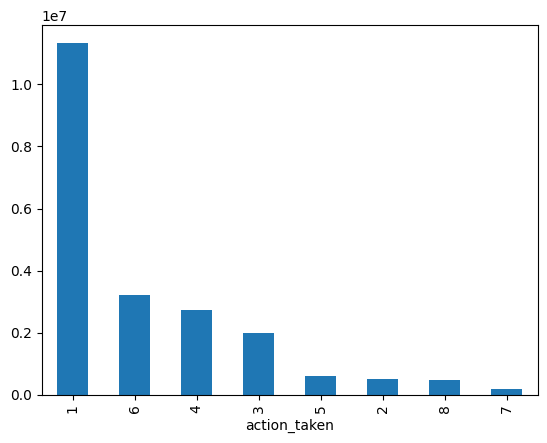

In [8]:
data_homePurchase['action_taken'].value_counts().plot(kind='bar')

**Values:**
- 1: Loan originated
- 2: Application approved but not accepted
- 3: Application denied
- 4: Application withdrawn by applicant
- 5: File closed for incompleteness
- 6: Purchased loan
- 7: Preapproval request denied
- 8: Preapproval request approved but not accepted

**Values will be grouped as:**
- 1,2,8: Approved
- 3,7: Denied

**Values to be removed:**
- 4, 5, 6

In [9]:
approved_data_homePurchase = data_homePurchase[(data_homePurchase['action_taken'] == 1) | (data_homePurchase['action_taken'] == 2) | (data_homePurchase['action_taken'] == 8)]
denied_data_homePurchase = data_homePurchase[(data_homePurchase['action_taken'] == 3) | (data_homePurchase['action_taken'] == 7)]

In [10]:
print(approved_data_homePurchase.shape)
print(denied_data_homePurchase.shape)

(12323579, 99)
(2158060, 99)


In [11]:
df = pd.concat([approved_data_homePurchase, denied_data_homePurchase], ignore_index=True)
print(df.shape)
# verify
print(approved_data_homePurchase.shape[0] + denied_data_homePurchase.shape[0])

(14481639, 99)
14481639


In [12]:
# Amout of rows removed because of application incompleteness, withdrawal, or other reasons
row_removed_B = data_homePurchase.shape[0] - df.shape[0]
print(f"Rows removed: {row_removed_B:,}")

Rows removed: 6,552,226


In [13]:
print(f"Total rows removed: {row_removed_A + row_removed_B:}")

Total rows removed: 25411144


In [14]:
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,254900ACUWEGW702BR80,35614,NY,36061.0,36061016002.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3607,36.57,99000,152.12,440,55,0
1,2022,254900ACUWEGW702BR80,35614,NY,36081.0,36081071100.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5687,55.57,99000,132.73,1769,597,65
2,2022,254900ACUWEGW702BR80,35154,NJ,34025.0,34025806400.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5135,19.57,128300,102.28,1416,1679,53
3,2022,254900ACUWEGW702BR80,35154,NJ,34029.0,34029715501.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4939,7.90,128300,62.91,685,997,40
4,2022,254900ACUWEGW702BR80,35004,NY,36059.0,36059411000.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6132,68.15,146400,63.34,1073,1708,69


In [15]:
df.shape

(14481639, 99)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14481639 entries, 0 to 14481638
Data columns (total 99 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   activity_year                             int64  
 1   lei                                       object 
 2   derived_msa-md                            int64  
 3   state_code                                object 
 4   county_code                               float64
 5   census_tract                              object 
 6   conforming_loan_limit                     object 
 7   derived_loan_product_type                 object 
 8   derived_dwelling_category                 object 
 9   derived_ethnicity                         object 
 10  derived_race                              object 
 11  derived_sex                               object 
 12  action_taken                              int64  
 13  purchaser_type                            int64  
 14  

In [17]:
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,254900ACUWEGW702BR80,35614,NY,36061.0,36061016002.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3607,36.57,99000,152.12,440,55,0
1,2022,254900ACUWEGW702BR80,35614,NY,36081.0,36081071100.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5687,55.57,99000,132.73,1769,597,65
2,2022,254900ACUWEGW702BR80,35154,NJ,34025.0,34025806400.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5135,19.57,128300,102.28,1416,1679,53
3,2022,254900ACUWEGW702BR80,35154,NJ,34029.0,34029715501.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4939,7.90,128300,62.91,685,997,40
4,2022,254900ACUWEGW702BR80,35004,NY,36059.0,36059411000.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6132,68.15,146400,63.34,1073,1708,69


In [18]:
df['interest_rate'].isna().sum()

np.int64(2189898)

In [19]:
df[df['interest_rate'].isna()].head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
17131,2022,5493008ETVHBTJEF0O91,99999,AR,5115.0,5115951601.0,NaN,Conventional:First Lien,Multifamily:Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6511,44.26,60200,88.46,1284,2619,37
18912,2022,5493005JF6BKCN6OY689,17460,OH,39093.0,39093070600.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,4393,19.99,85400,89.79,1505,1914,65
19130,2022,5493006ZBGVXBAMCRG16,99999,FL,NaN,NaN,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,0,0.00,0,0.00,0,0,0
19178,2022,5493006ZBGVXBAMCRG16,99999,FL,NaN,NaN,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,0,0.00,0,0.00,0,0,0
19603,2022,254900BDGU9FU91PQA51,99999,OH,39161.0,39161020900.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3616,10.12,74900,98.62,1116,1668,60


In [20]:
df.shape

(14481639, 99)

# Result:

* Write the result data (df) to 'df_trimmed.csv' in Step 2 Folder ready for EDA

In [21]:
df.to_csv('../Step2/trimmed_dataset_fromStep1.csv', index=False)